## Initializing Stuff

In [1]:
import numpy as np
import pandas as pd
import gymnasium as gym

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical, Normal

from tqdm import tqdm
from itertools import count
from typing import List, Union

## Define the actor and Critic Nets

In [2]:
class QApproximator(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=64):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, int(hidden_dim/2))
        self.fc3 = nn.Linear(int(hidden_dim/2), output_dim)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        q_values = self.fc3(x)
        return q_values


class PolicyNet(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=64):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, int(hidden_dim/2))
        self.fc3 = nn.Linear(int(hidden_dim/2), output_dim)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        actor_prob_logits = self.fc3(x)
        return actor_prob_logits


## Define the Q-Agent

In [3]:
class BaseACAgent(object):
    def __init__(
        self,
        env: gym.Env,
        policy_net: nn.Module,
        critic_net: nn.Module,
        use_cuda: bool = False
    ):
        self.env = env
        # if gpu is to be used
        self.device = torch.device("cuda" if use_cuda and torch.cuda.is_available() else "cpu")

        self.policy_net = policy_net.to(self.device)
        self.critic_net = critic_net.to(self.device)

        # Cumulative reward of each episode
        self.tr_rewards: List[float] = list()
        self.ev_rewards: List[float] = list()
        self.tr_avg_rewards: List[float] = list()
        self.tr_avg_duration: Union[List[int], List[float]] = list()
        # Number of time steps taken in each episode
        self.tr_durations: Union[List[int], List[float]] = list()
        self.ev_durations: Union[List[int], List[float]] = list()
        self.ev_avg_rewards: List[float] = list()
        self.ev_avg_duration: Union[List[int], List[float]] = list()

    def choose_action(self, state):
        actor_prob_logits = self.policy_net(state)
        dist = Categorical(logits=actor_prob_logits)
        action = dist.sample()
        action_log_prob = dist.log_prob(action)

        return action, action_log_prob

    def evaluate(
        self,
        num_episodes: int = 150,
        report_every_n_episodes: int = 10,
        quiet: bool = False
    ):
        prog_bar = tqdm(range(num_episodes), desc='Evaluation Episode', disable=quiet)
        for episode in prog_bar:
            ep_reward = torch.tensor(0.)

            state, _ = self.env.reset()
            state = torch.tensor(state).to(self.device)
            for steps in count():
                with torch.no_grad():
                    action, _ = self.choose_action(state)

                    new_state, reward, terminated, truncated, _ = self.env.step(action.item())
                    new_state = torch.tensor(new_state).to(self.device)

                    ep_reward += reward
                    state = new_state

                if terminated or truncated:
                    self.ev_rewards.append(ep_reward)
                    self.ev_durations.append(steps)
                    self.ev_avg_rewards.append(np.mean(self.ev_rewards[-report_every_n_episodes:]))
                    self.ev_avg_duration.append(np.mean(self.ev_durations[-report_every_n_episodes:]))
                    if episode % report_every_n_episodes == 0:
                        prog_bar.set_postfix_str(
                            f"{report_every_n_episodes}-episode average reward: {self.ev_avg_rewards[-1]}, "\
                            f"{report_every_n_episodes}-episode average len: {self.ev_avg_duration[-1]}"
                        )
                    break

    def plot_performance(self):
        import matplotlib.pyplot as plt

        plt.rcParams["figure.figsize"] = (60,28)
        plt.rcParams["font.size"] = 44
        
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)

        ax1.set_xlabel('Training Episodes')
        ax1.set_ylabel('Running Duration')
        ax1.plot(self.tr_durations, linewidth=6, label='Per Episode', color='#0077b6')
        ax1.plot(self.tr_avg_duration, linewidth=6, label='Running Average', color='#420c09')
        ax1.legend()
        ax1.grid(True)

        ax2.set_xlabel('Training Episodes')
        ax2.set_ylabel('Epiosde Reward')
        ax2.plot(self.tr_rewards, linewidth=6, label='Per Episode', color='#0077b6')
        ax2.plot(self.tr_avg_rewards, linewidth=6, label='Running Average', color='#420c09')
        ax2.legend()
        ax2.grid(True)

        ax3.set_xlabel('Evaluation Episodes')
        ax3.set_ylabel('Running Duration')
        ax3.plot(self.ev_durations, linewidth=6, label='Per Episode', color='#0077b6')
        ax3.plot(self.ev_avg_duration, linewidth=6, label='Running Average', color='#420c09')
        ax3.legend()
        ax3.grid(True)

        ax4.set_xlabel('Evaluation Episodes')
        ax4.set_ylabel('Epiosde Reward')
        ax4.plot(self.ev_rewards, linewidth=6, label='Per Episode', color='#0077b6')
        ax4.plot(self.ev_avg_rewards, linewidth=6, label='Running Average', color='#420c09')
        ax4.legend()
        ax4.grid(True)

        plt.show()


In [4]:
class QACAgent(BaseACAgent):
    def train(
        self,
        ac_optimizer: optim.Optimizer,
        cr_optimizer: optim.Optimizer,
        num_episodes: int = int(1e3),
        disc_factor: float = .99,
        report_every_n_episodes: int = 30,
        quiet: bool = False,
        early_stopping_rwd: float = float('inf'),
        early_stopping_window: int = 10
    ):
        sheduler_args = {
            'milestones': [int(num_episodes/3), int(3*num_episodes/4)],
            'gamma': .5
        }
        ac_scheduler = optim.lr_scheduler.MultiStepLR(ac_optimizer, **sheduler_args)
        cr_scheduler = optim.lr_scheduler.MultiStepLR(ac_optimizer, **sheduler_args)

        prog_bar = tqdm(range(num_episodes), desc='Training Episode', disable=quiet)
        for episode in prog_bar:
            ep_reward = torch.tensor(0.)

            state, _ = self.env.reset()
            state = torch.tensor(state).to(self.device)
            for steps in count():
                action, log_prob = self.choose_action(state)

                new_state, reward, terminated, truncated, _ = self.env.step(action.item())
                new_state = torch.tensor(new_state).to(self.device)                
                ep_reward += reward

                next_action, _ = self.choose_action(new_state)

                # Get Q values
                qvalue = self.critic_net(state)[action.item()]
                next_qvalue = self.critic_net(new_state)[next_action.item()]

                q_target = reward + disc_factor * next_qvalue * int(not terminated)

                # Critic loss
                criterion = nn.SmoothL1Loss()
                critic_loss = criterion(qvalue, q_target)

                # Actor loss
                actor_loss = -log_prob * (q_target-qvalue).detach()

                ac_optimizer.zero_grad()
                actor_loss.backward()
                # In-place gradient clipping to prevent exploding gradients.
                # torch.nn.utils.clip_grad_value_(self.policy_net.parameters(), 10)
                ac_optimizer.step()

                cr_optimizer.zero_grad()
                critic_loss.backward()
                # In-place gradient clipping to prevent exploding gradients.
                # torch.nn.utils.clip_grad_value_(self.critic_net.parameters(), 10)
                cr_optimizer.step()

                # Move ahead
                state = new_state

                if terminated or truncated:
                    self.tr_rewards.append(ep_reward)
                    self.tr_durations.append(steps)
                    self.tr_avg_rewards.append(np.mean(self.tr_rewards[-report_every_n_episodes:]))
                    self.tr_avg_duration.append(np.mean(self.tr_durations[-report_every_n_episodes:]))
                    if episode % report_every_n_episodes == 0:
                        prog_bar.set_postfix_str(
                            f"{report_every_n_episodes}-episode average reward: {self.tr_avg_rewards[-1]}, "\
                            f"{report_every_n_episodes}-episode average len: {self.tr_avg_duration[-1]}"
                        )
                    break

            # Stop training if the last `early_stopping_window` reward
            # running averages are above `early_stopping_rwd`
            if all([rwd > early_stopping_rwd
                    for rwd in self.tr_avg_rewards[-early_stopping_window:]]):
                break

            ac_scheduler.step()
            cr_scheduler.step()


## Part 1: CartPole-v1

### Definitions Q Actor-Critic

In [5]:
# Hyperparams
hidden_size = 64
ac_learning_rate = 1e-3
cr_learning_rate = 1e-3

cartenv = gym.make('CartPole-v1')

num_inputs = cartenv.observation_space.shape[0]
num_outputs = cartenv.action_space.n

actor = PolicyNet(num_inputs, num_outputs, hidden_size)
critic = QApproximator(num_inputs, num_outputs, hidden_size)

ac_optimizer = optim.AdamW(actor.parameters(), lr=ac_learning_rate)
cr_optimizer = optim.AdamW(critic.parameters(), lr=cr_learning_rate)

### Train the agent

In [6]:
qac_agent = QACAgent(cartenv, actor, critic, use_cuda=False)

qac_agent.train(ac_optimizer, cr_optimizer, num_episodes=2048, early_stopping_rwd=475)

Training Episode:  45%|████▌     | 929/2048 [08:12<09:53,  1.89it/s, 30-episode average reward: 422.9333190917969, 30-episode average len: 421.93333333333334] 


### Evaluate the agent

In [19]:
qac_agent.evaluate(num_episodes=200)

Evaluation Episode: 100%|██████████| 200/200 [00:34<00:00,  5.73it/s, 10-episode average reward: 500.0, 10-episode average len: 499.0]


### Plot the Performance

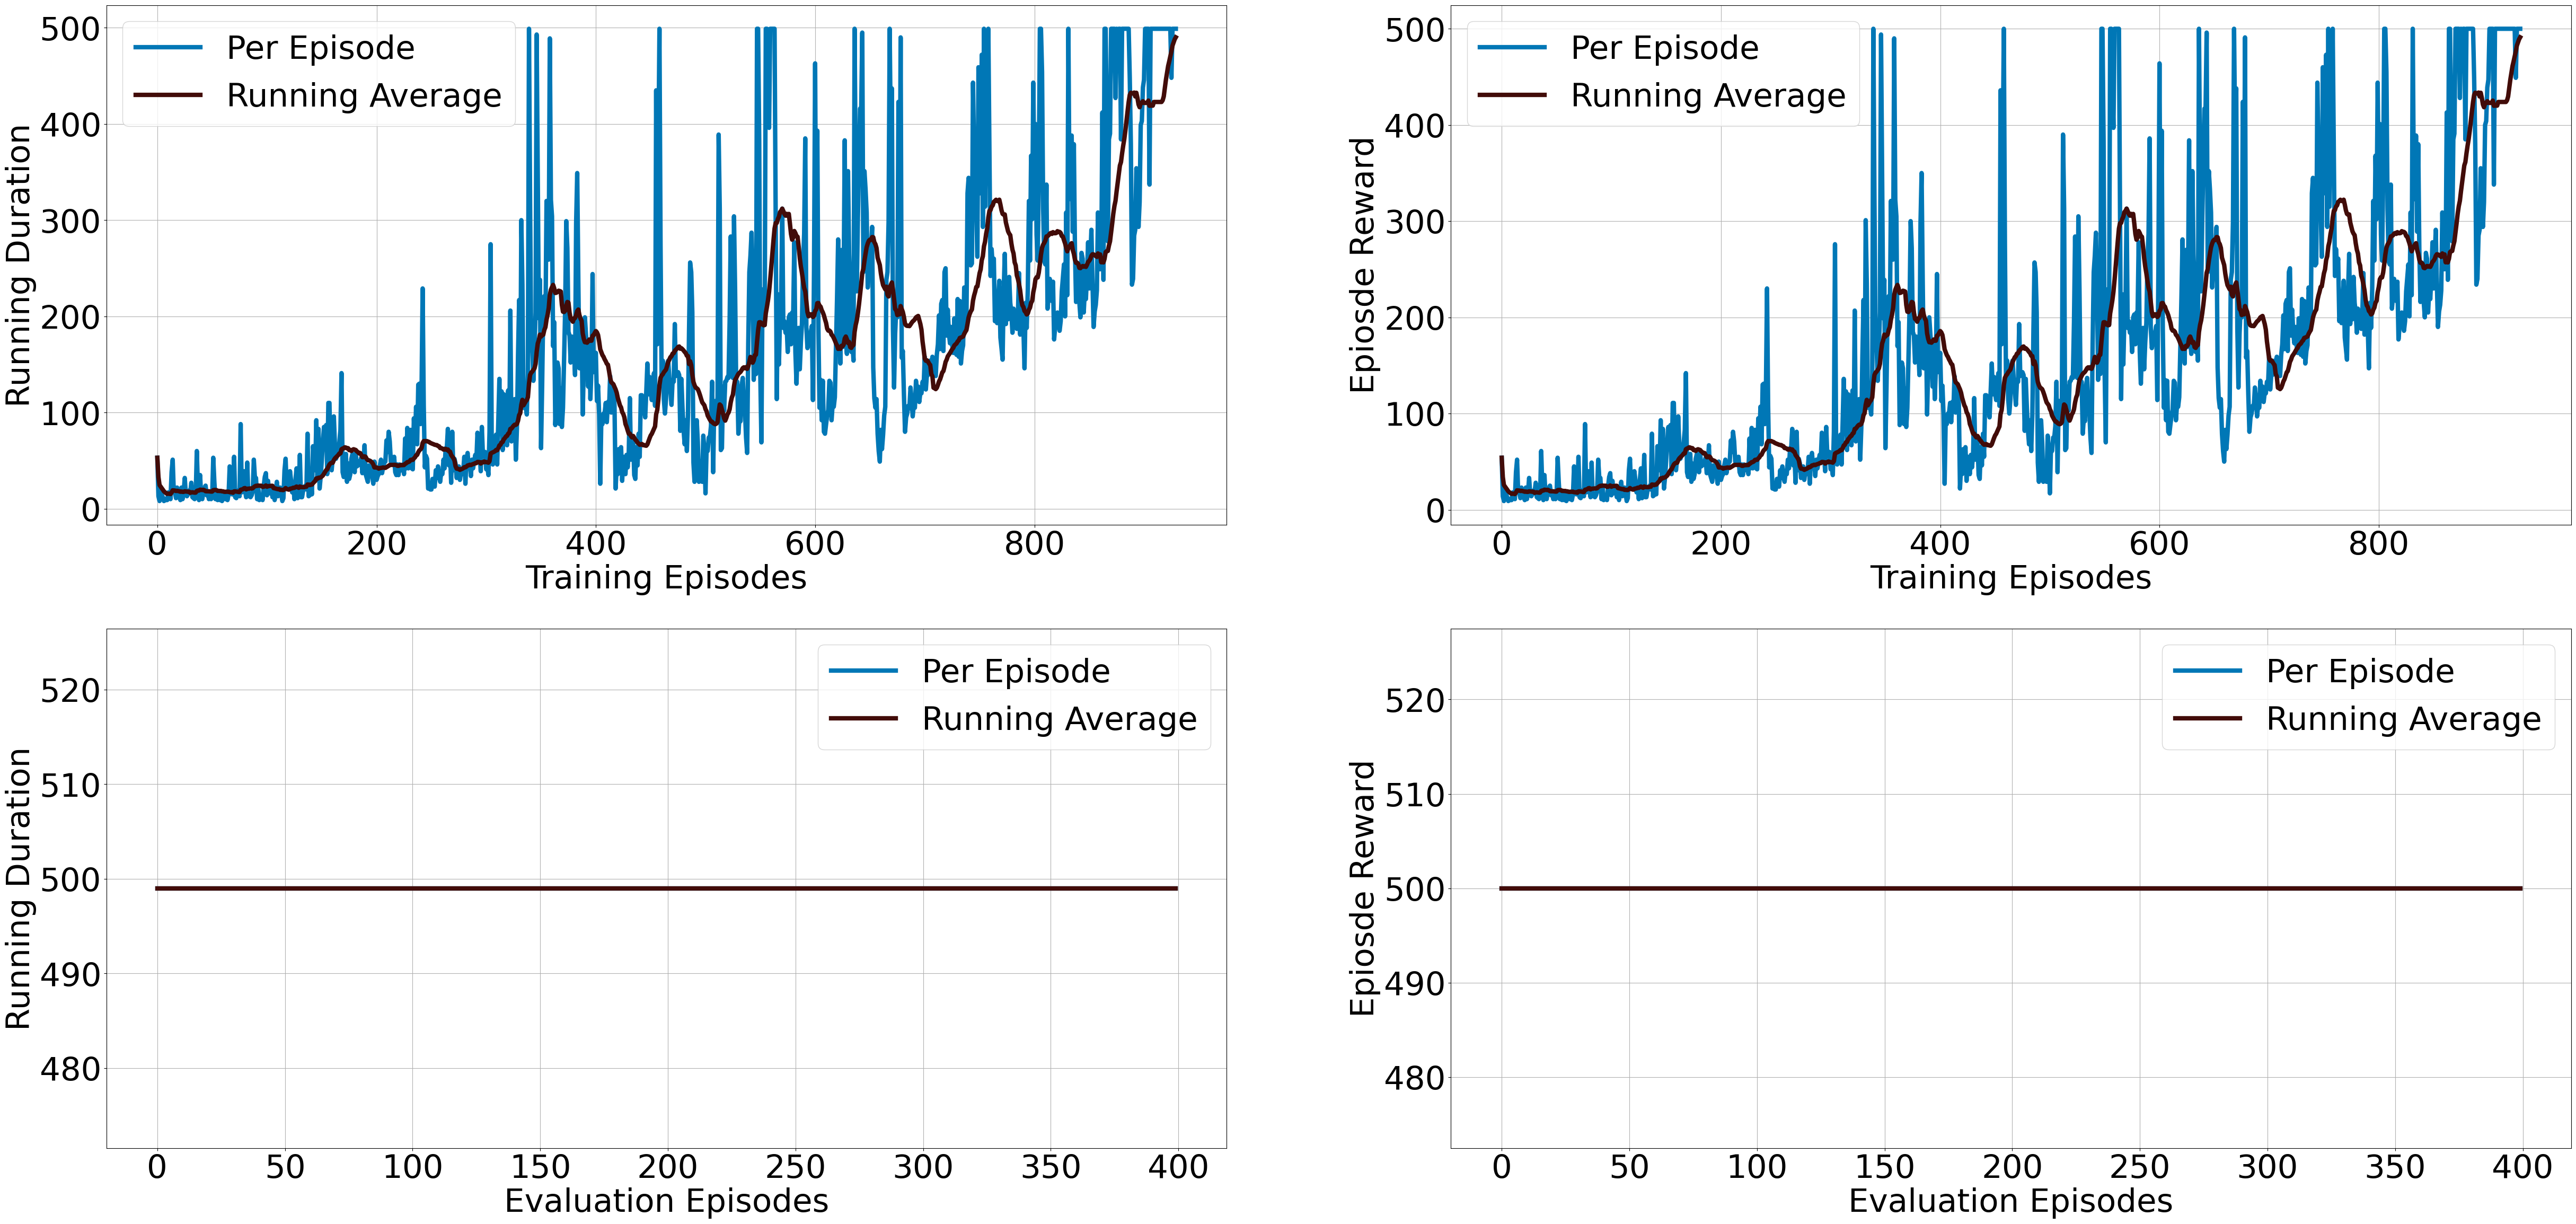

In [20]:
qac_agent.plot_performance()

In [18]:
# torch.save(actor.state_dict(),'m44_saileshr_assignment3_qac_actor_cartpolev1.pth')
# torch.save(critic.state_dict(),'m44_saileshr_assignment3_qac_critic_cartpolev1.pth')

## Part 2.1: LunarLander-v2

### Definitions Q Actor Critic

In [ ]:
# Hyperparams
hidden_size = 64
ac_learning_rate = 1e-3
cr_learning_rate = 1e-3

lunarenv = gym.make('LunarLander-v2')

num_inputs = lunarenv.observation_space.shape[0]
num_outputs = lunarenv.action_space.n

actor = PolicyNet(num_inputs, num_outputs, hidden_size)
critic = QApproximator(num_inputs, num_outputs, hidden_size)

ac_optimizer = optim.AdamW(actor.parameters(), lr=ac_learning_rate)
cr_optimizer = optim.AdamW(critic.parameters(), lr=cr_learning_rate)

### Train the agent

In [ ]:
qac_agent = QACAgent(lunarenv, actor, critic, use_cuda=True)

qac_agent.train(ac_optimizer, cr_optimizer, num_episodes=2**13, early_stopping_rwd=200)

### Evaluate the agent

In [ ]:
qac_agent.evaluate(num_episodes=200)

### Plot the Performance

In [ ]:
qac_agent.plot_performance()

## Continuous Environment

In [5]:
class ContinuousQApproximator(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=64):
        super().__init__()
        input_dim = state_dim + action_dim
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, int(hidden_dim/2))
        self.fc3 = nn.Linear(int(hidden_dim/2), 1)
    
    def forward(self, state, action):
        x = torch.cat((state, action), dim=-1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        q_value = self.fc3(x)
        return q_value


class ContinuousPolicyNet(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=64, action_scaler: float = 1.):
        super().__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, int(hidden_dim/2))
        self.mu_net = nn.Linear(int(hidden_size/2), action_dim)
        self.sigma_net = nn.Linear(int(hidden_size/2), action_dim)

        self.scaler = action_scaler

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        mu = self.scaler * F.tanh(self.mu_net(x))
        sigma = F.softplus(self.sigma_net(x)) # ReLU to ensure positive values
        return mu, sigma


### Continuous QAC Agent

In [6]:
class ContinuousQACAgent(BaseACAgent):
    def choose_action(self, state):
        mu, sigma = self.policy_net(state)

        eps = 1e-6 # For numerical stability

        dist = Normal(mu+eps, sigma+eps)
        action = dist.sample()
        action_log_prob = dist.log_prob(action)

        return action, action_log_prob

    def train(
        self,
        ac_optimizer: optim.Optimizer,
        cr_optimizer: optim.Optimizer,
        num_episodes: int = int(1e3),
        disc_factor: float = .99,
        report_every_n_episodes: int = 30,
        quiet: bool = False,
        early_stopping_rwd: float = float('inf'),
        early_stopping_window: int = 10
    ):
        sheduler_args = {
            'milestones': [int(num_episodes/3), int(3*num_episodes/4)],
            'gamma': .5
        }
        ac_scheduler = optim.lr_scheduler.MultiStepLR(ac_optimizer, **sheduler_args)
        cr_scheduler = optim.lr_scheduler.MultiStepLR(ac_optimizer, **sheduler_args)

        prog_bar = tqdm(range(num_episodes), desc='Training Episode', disable=quiet)
        for episode in prog_bar:
            ep_reward = torch.tensor(0.)

            state, _ = self.env.reset()
            state = torch.tensor(state).float().to(self.device)
            for steps in count():
                action, log_prob = self.choose_action(state)

                new_state, reward, terminated, truncated, _ = self.env.step(action.cpu().numpy())
                new_state = torch.tensor(new_state).float().to(self.device)                
                ep_reward += reward

                next_action, _ = self.choose_action(new_state)

                # Get Q values
                qvalue = self.critic_net(state, action)
                next_qvalue = self.critic_net(new_state, next_action)

                q_target = reward + disc_factor * next_qvalue * int(not terminated)

                # Critic loss
                criterion = nn.SmoothL1Loss()
                critic_loss = criterion(qvalue, q_target)

                # Actor loss
                actor_loss = -log_prob * (q_target-qvalue).detach()

                ac_optimizer.zero_grad()
                actor_loss.backward()
                # In-place gradient clipping to prevent exploding gradients.
                # torch.nn.utils.clip_grad_value_(self.policy_net.parameters(), 10)
                ac_optimizer.step()

                cr_optimizer.zero_grad()
                critic_loss.backward()
                # In-place gradient clipping to prevent exploding gradients.
                # torch.nn.utils.clip_grad_value_(self.critic_net.parameters(), 10)
                cr_optimizer.step()

                # Move ahead
                state = new_state

                if terminated or truncated:
                    self.tr_rewards.append(ep_reward)
                    self.tr_durations.append(steps)
                    self.tr_avg_rewards.append(np.mean(self.tr_rewards[-report_every_n_episodes:]))
                    self.tr_avg_duration.append(np.mean(self.tr_durations[-report_every_n_episodes:]))
                    if episode % report_every_n_episodes == 0:
                        prog_bar.set_postfix_str(
                            f"{report_every_n_episodes}-episode average reward: {self.tr_avg_rewards[-1]}, "\
                            f"{report_every_n_episodes}-episode average len: {self.tr_avg_duration[-1]}"
                        )
                    break

            # Stop training if the last `early_stopping_window` reward
            # running averages are above `early_stopping_rwd`
            if all([rwd > early_stopping_rwd
                    for rwd in self.tr_avg_rewards[-early_stopping_window:]]):
                break

            ac_scheduler.step()
            cr_scheduler.step()

    def evaluate(
        self,
        num_episodes: int = 150,
        report_every_n_episodes: int = 10,
        quiet: bool = False
    ):
        prog_bar = tqdm(range(num_episodes), desc='Evaluation Episode', disable=quiet)
        for episode in prog_bar:
            ep_reward = torch.tensor(0.)

            state, _ = self.env.reset()
            state = torch.tensor(state).float().to(self.device)
            for steps in count():
                with torch.no_grad():
                    action, _ = self.choose_action(state)

                    new_state, reward, terminated, truncated, _ = self.env.step(action.cpu().numpy())
                    new_state = torch.tensor(new_state).float().to(self.device)

                    ep_reward += reward
                    state = new_state

                if terminated or truncated:
                    self.ev_rewards.append(ep_reward)
                    self.ev_durations.append(steps)
                    self.ev_avg_rewards.append(np.mean(self.ev_rewards[-report_every_n_episodes:]))
                    self.ev_avg_duration.append(np.mean(self.ev_durations[-report_every_n_episodes:]))
                    if episode % report_every_n_episodes == 0:
                        prog_bar.set_postfix_str(
                            f"{report_every_n_episodes}-episode average reward: {self.ev_avg_rewards[-1]}, "\
                            f"{report_every_n_episodes}-episode average len: {self.ev_avg_duration[-1]}"
                        )
                    break

## InvertedPendulum-v4

### Definitions Q Actor-Critic

In [7]:
# Hyperparams
hidden_size = 32
ac_learning_rate = 2e-3
cr_learning_rate = 2e-3

pendulumenv = gym.make('InvertedPendulum-v4')

state_dim = pendulumenv.observation_space.shape[0]
action_dim = pendulumenv.action_space.shape[0]

actor = ContinuousPolicyNet(state_dim, action_dim, hidden_size, action_scaler=3.)
critic = ContinuousQApproximator(state_dim, action_dim, hidden_size)

ac_optimizer = optim.AdamW(actor.parameters(), lr=ac_learning_rate)
cr_optimizer = optim.AdamW(critic.parameters(), lr=cr_learning_rate)

### Train the agent

In [8]:
qac_agent = ContinuousQACAgent(pendulumenv, actor, critic, use_cuda=True)

qac_agent.train(ac_optimizer, cr_optimizer, num_episodes=2**16, early_stopping_rwd=990)

Training Episode:  82%|████████▏ | 54002/65536 [18:52:51<4:01:57,  1.26s/it, 30-episode average reward: 892.7333374023438, 30-episode average len: 891.7333333333333]      


### Evaluate the agent

In [9]:
qac_agent.evaluate(num_episodes=200)

Evaluation Episode: 100%|██████████| 200/200 [04:13<00:00,  1.27s/it, 10-episode average reward: 1000.0, 10-episode average len: 999.0]           


### Plot the Performance

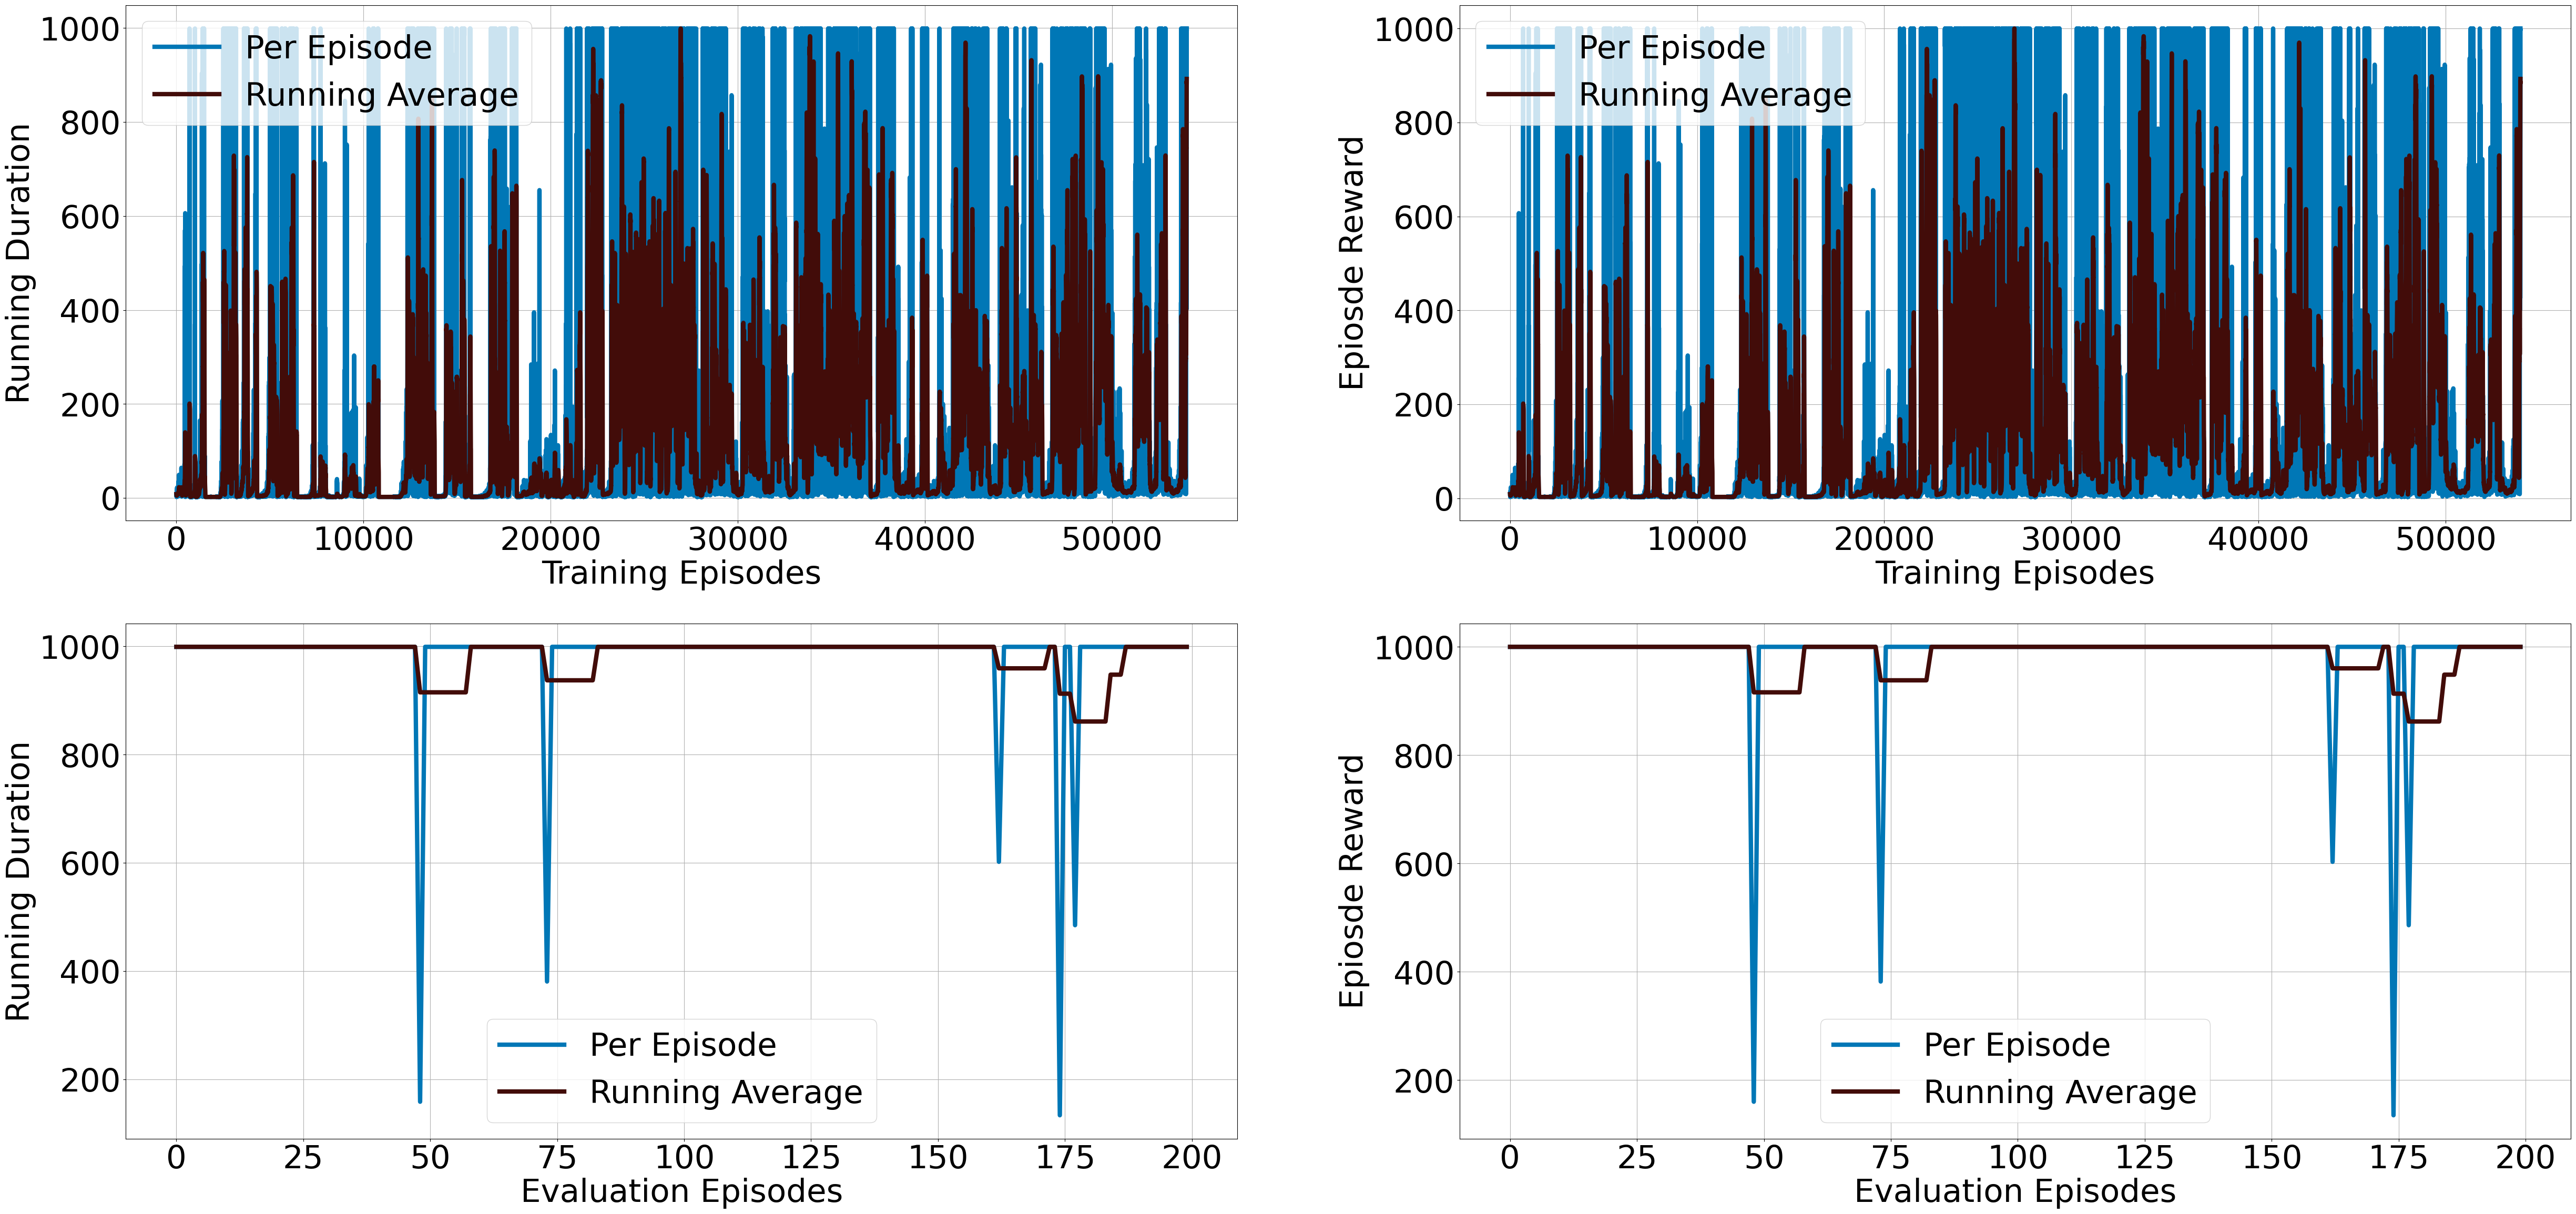

In [10]:
qac_agent.plot_performance()

In [11]:
# torch.save(actor.state_dict(),'m44_saileshr_assignment3_qac_actor_invpendulum.pth')
# torch.save(critic.state_dict(),'m44_saileshr_assignment3_qac_critic_invpendulum.pth')